<a href="https://colab.research.google.com/github/geekevgin/-Python/blob/main/brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#импорт библиотек 
import pandas as pd
import numpy as np
import pickle
!pip install catboost

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
import xgboost as xgb
import catboost as catb
import lightgbm as lgbm
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.2 MB/s 


In [2]:
# Функция описания категориальных данных
def describe_categorical_var(series):
    print(series.value_counts().head(10), '\n')
    print(series.value_counts(normalize=True).head(), '\n')
    print('Column has {} unique values'.format(series.nunique()))
    print('Column has {} ({}%) missing values\n'.
          format(series.isnull().sum(), series.isnull().sum()/len(series)))

In [3]:
# Функция описания числовых данных
def describe_numerical_var(series):
    p75 = series.quantile(0.75)
    p25 = series.quantile(0.25)
    IQR = p75 - p25
    series.hist()
    print(series.describe(), '\n')
    print('IQR = {}'.format(IQR))
    print('Outliers: {} and {}\n'.format(p25 - 1.5*IQR, p75 + 1.5*IQR))
    print('Column has {} ({}%) missing values\n'.
          format(series.isnull().sum(), series.isnull().sum()/len(series)))

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [5]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [6]:
# импорт данных
from google.colab import files
uploaded = files.upload()
uploaded = files.upload()

Saving course_project_train.csv to course_project_train.csv


Saving course_project_test.csv to course_project_test.csv


In [7]:
#изучим данные
df_train = pd.read_csv('course_project_train.csv')
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [8]:
df_test = pd.read_csv('course_project_test.csv')
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [9]:
#посмотрим типы данных и есть ли пропуски
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

**EDA**. Начнем обрабатывать пропуски, выбросы и создавать новые переменные

In [10]:
# создадим новый бинарный признак по задолженности, где 1 соотвествует задолжености и заменим пустые значения на 0
df_train['delay'] = 1
df_train.loc[(df_train['Months since last delinquent'].isnull()), 'delay'] = 0

In [11]:
#создаем бинарный признак по доходу, где 0 - доход неизвестен.
df_train['income'] = 0
#заменим пустые значения
df_train.loc[(df_train['Annual Income'].isnull()), 'income'] = 1
#создаем переменную по среднему годовому доходу
annual_income_median = df_train['Annual Income'].median()
#заменяем пустые значения медианой
df_train['Annual Income'].fillna(annual_income_median, inplace=True)


In [12]:
#создадим переменную средней месячной задолжености
months_since_last_delinquent_median = df_train['Months since last delinquent'].median()
#заменям пропуски медианой
df_train['Months since last delinquent'].fillna(months_since_last_delinquent_median, inplace=True)

In [13]:
#посмотрим уникальные значения 
unique_years_in_current_job = df_train['Years in current job'].unique()
#возьмем уникальные значения опыта работы в годах
experiance = unique_years_in_current_job[1:]
#Заменим пустые значения рандомным выбором 
df_train['Years in current job'].fillna(random.choice(experiance), inplace=True)

In [14]:
#оценим другую категориальную переменную и ее значеня
df_train.Bankruptcies.value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [15]:
#Заменим nan значения на 0, тк их больше всех
df_train['Bankruptcies'].fillna(0 , inplace=True)

In [16]:
#создаем признак где неизвестные данные по credit score 
df_train['unknown_credit_score'] = 0
credit_score_median = df_train['Credit Score'].median()
df_train.loc[(df_train['Credit Score'].isnull()), 'unknown_credit_score'] = 1
df_train['Credit Score'].fillna(credit_score_median, inplace=True)


In [17]:
df_train['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [18]:
#Сделаем признак бинарным
df_train['term_to_binary'] = df_train['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)

In [21]:
#оцениваем пустые значения
df_train.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
delay                           0
income                          0
unknown_credit_score            0
term_to_binary                  0
dtype: int64

In [22]:
#оценим целевую переменную
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

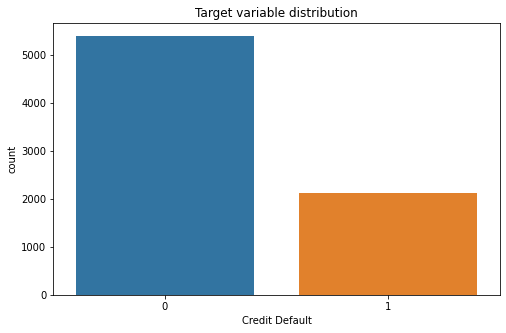

In [23]:
#визуализируем целевую как распределяются значения
plt.figure(figsize=(8, 5))

sns.countplot(x= 'Credit Default', data = df_train)

plt.title('Target variable distribution')
plt.show()

In [24]:
#описательные статистики
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,delay,income,unknown_credit_score,term_to_binary
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,1.325286e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,33.227467,0.116933,1.187318e+07,2.898332e+05,18314.454133,1063.877333,0.281733,0.455867,0.207600,0.207600,0.740800
std,7.567551e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,14.703950,0.346904,3.192612e+07,3.178714e+05,11926.764673,1438.335832,0.449874,0.498082,0.405616,0.405616,0.438225
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.311330e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,32.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,718.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.499974e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,32.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,740.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
print(f"Train:\t{df_train.shape[0]}\t and {df_train.shape[1]} features")
print(f"Test:\t{df_test.shape[0]}\t and {df_test.shape[1]} features")

Train:	7500	 and 21 features
Test:	2500	 and 16 features


In [26]:
#оценим категориальные данные
df_catg_features = df_train.select_dtypes('object')
df_catg_features.head()

,Home Ownership,Years in current job,Purpose,Term
0,Own Home,10+ years,debt consolidation,Short Term
1,Own Home,10+ years,debt consolidation,Long Term
2,Home Mortgage,8 years,debt consolidation,Short Term
3,Own Home,6 years,debt consolidation,Short Term
4,Rent,8 years,debt consolidation,Short Term


In [27]:
for column in df_catg_features:
    print('Analyzing \'{}\' column'.format(column))
    describe_categorical_var(df_train[column])

Analyzing 'Home Ownership' column
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64 

Home Mortgage    0.484933
Rent             0.427200
Own Home         0.086267
Have Mortgage    0.001600
Name: Home Ownership, dtype: float64 

Column has 4 unique values
Column has 0 (0.0%) missing values

Analyzing 'Years in current job' column
10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
Name: Years in current job, dtype: int64 

10+ years    0.360400
2 years      0.094000
3 years      0.082667
< 1 year     0.075067
5 years      0.068800
Name: Years in current job, dtype: float64 

Column has 11 unique values
Column has 0 (0.0%) missing values

Analyzing 'Purpose' column
debt consolidation    5944
other                  665
home improvements      412
business loan          129
buy a car         

In [28]:
#оценим количественные признаки типа float64
df_num_features_float = df_train.select_dtypes( include = 'float64')
df_num_features_float.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,482087.0,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,99999999.0,47386.0,7914.0,749.0
1,1025487.0,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,264968.0,394972.0,18373.0,737.0
2,751412.0,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,99999999.0,308389.0,13651.0,742.0
3,805068.0,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,121396.0,95855.0,11338.0,694.0
4,776264.0,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,125840.0,93309.0,7180.0,719.0


Analyzing 'Annual Income' column
count    7.500000e+03
mean     1.325286e+06
std      7.567551e+05
min      1.645970e+05
25%      9.311330e+05
50%      1.168386e+06
75%      1.499974e+06
max      1.014934e+07
Name: Annual Income, dtype: float64 

IQR = 568841.0
Outliers: 77871.5 and 2353235.5

Column has 0 (0.0%) missing values

Analyzing 'Tax Liens' column
count    7500.000000
mean        0.030133
std         0.271604
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Tax Liens, dtype: float64 

IQR = 0.0
Outliers: 0.0 and 0.0

Column has 0 (0.0%) missing values

Analyzing 'Number of Open Accounts' column
count    7500.000000
mean       11.130933
std         4.908924
min         2.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        43.000000
Name: Number of Open Accounts, dtype: float64 

IQR = 6.0
Outliers: -1.0 and 23.0

Column has 0 (0.0%) missing values

Analyzing 'Years of Credit History' col

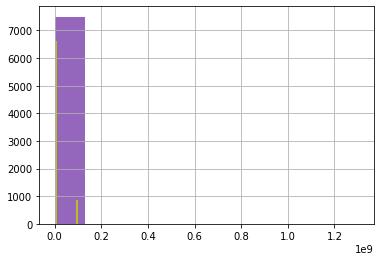

In [29]:
for column in df_num_features_float:
    print('Analyzing \'{}\' column'.format(column))
    describe_numerical_var(df_train[column])

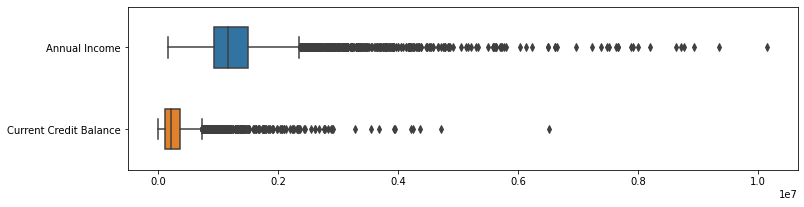

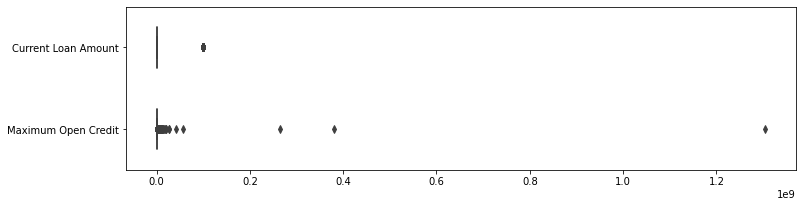

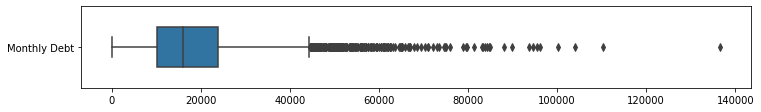

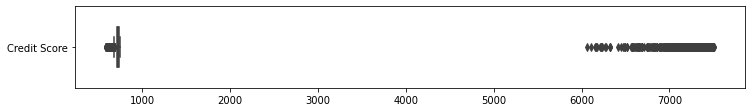

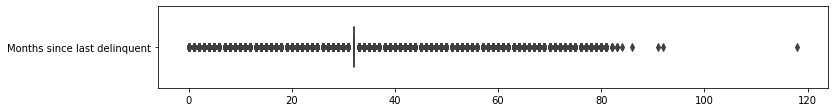

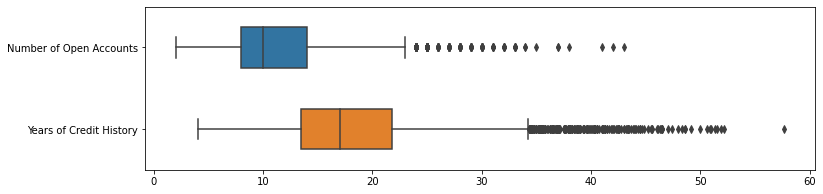

In [30]:
#Построим boxplot и посмотрим выбросы
features_boxplot = [
    ['Annual Income', 'Current Credit Balance'],
    ['Current Loan Amount', 'Maximum Open Credit'],
    ['Monthly Debt'],
    ['Credit Score'],
    ['Months since last delinquent'],
    ['Number of Open Accounts', 'Years of Credit History']
]

for i in features_boxplot:
    plt.figure(figsize=(12, 1.5*len(i)))
    sns.boxplot(data=df_train[i], width=0.5, orient='h')
    plt.show()

In [31]:
#разобьем признаки на целевую, числовые и категориальные и новые
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
NUMB_FEATURE_NAMES = ['Annual Income','Tax Liens','Number of Open Accounts','Years of Credit History',
                     'Maximum Open Credit','Number of Credit Problems','Months since last delinquent',
                     'Bankruptcies','Current Loan Amount','Current Credit Balance','Monthly Debt','Credit Score']
CAT_FEATURE_NAMES = ['Years in current job','Home Ownership','Purpose','Term']

NEW_FEATURE_NAMES = ['delay','income','unknown_credit_score','term_to_binary']

In [32]:
y = df_train[[TARGET_NAME]]
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Credit Default  7500 non-null   int64
dtypes: int64(1)
memory usage: 58.7 KB


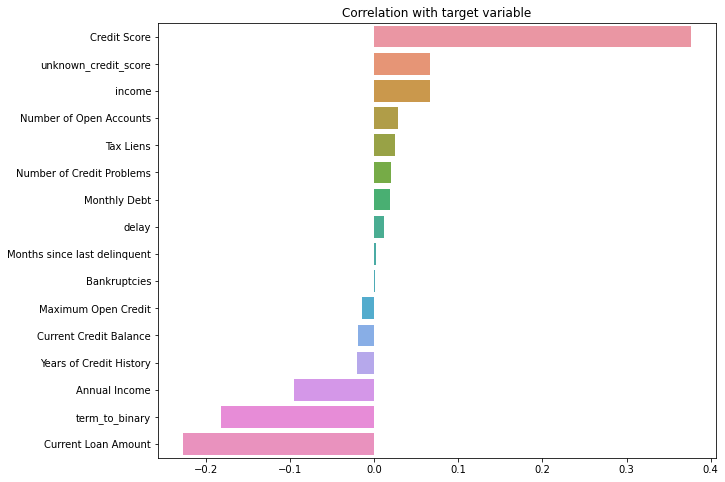

In [33]:
#посмотрим как коррелируют признаки с целевой
corr_with_target = df_train[BASE_FEATURE_NAMES + 
                            NEW_FEATURE_NAMES + 
                            [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [34]:
SELECTED_FEATURE_NAMES = NUMB_FEATURE_NAMES + NEW_FEATURE_NAMES


X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=11)

**Приступим** **к** **обучению**

In [35]:
#Нормализация
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUMB_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMB_FEATURE_NAMES])

df_train = df_norm.copy()

In [36]:
#балансировка данных
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3768
1    2964
Name: Credit Default, dtype: int64

In [37]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [38]:
#LogisticRegression
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.65      0.78      0.71      3768
           1       0.63      0.47      0.54      2964

    accuracy                           0.64      6732
   macro avg       0.64      0.63      0.63      6732
weighted avg       0.64      0.64      0.64      6732

TEST

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1619
           1       0.47      0.48      0.48       631

    accuracy                           0.71      2250
   macro avg       0.64      0.64      0.64      2250
weighted avg       0.71      0.71      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1284  335
1                328  303


In [39]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)


TRAIN

              precision    recall  f1-score   support

           0       0.77      0.80      0.79      3768
           1       0.74      0.70      0.72      2964

    accuracy                           0.76      6732
   macro avg       0.76      0.75      0.75      6732
weighted avg       0.76      0.76      0.76      6732

TEST

              precision    recall  f1-score   support

           0       0.76      0.70      0.73      1619
           1       0.36      0.43      0.39       631

    accuracy                           0.63      2250
   macro avg       0.56      0.57      0.56      2250
weighted avg       0.65      0.63      0.64      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1135  484
1                358  273


In [40]:
#XGBOOST
model_xgb = xgb.XGBClassifier(random_state=11)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.87      0.79      3768
           1       0.78      0.56      0.65      2964

    accuracy                           0.74      6732
   macro avg       0.75      0.72      0.72      6732
weighted avg       0.74      0.74      0.73      6732

TEST

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1619
           1       0.53      0.47      0.50       631

    accuracy                           0.74      2250
   macro avg       0.67      0.66      0.66      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1357  262
1                332  299


In [41]:
#LGBM
model_lgbm = lgbm.LGBMClassifier(random_state=11)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      3768
           1       0.94      0.87      0.90      2964

    accuracy                           0.92      6732
   macro avg       0.92      0.91      0.92      6732
weighted avg       0.92      0.92      0.92      6732

TEST

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1619
           1       0.52      0.45      0.48       631

    accuracy                           0.73      2250
   macro avg       0.66      0.64      0.65      2250
weighted avg       0.72      0.73      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1353  266
1                345  286


In [42]:
#CATboost
model_catb = catb.CatBoostClassifier(silent=True, random_state=11)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      3768
           1       0.93      0.84      0.88      2964

    accuracy                           0.90      6732
   macro avg       0.91      0.90      0.90      6732
weighted avg       0.90      0.90      0.90      6732

TEST

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1619
           1       0.56      0.45      0.50       631

    accuracy                           0.75      2250
   macro avg       0.68      0.65      0.66      2250
weighted avg       0.73      0.75      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1394  225
1                348  283


In [43]:
#подборка лучшей модели и гиперпараметров
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=11)

In [44]:
#создадим сетку параметров
params = {'n_estimators':[500, 700, 1000, 1200, 1500, 2000],
          'max_depth':[3, 5, 7]}

In [45]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [46]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

CPU times: user 5.66 s, sys: 758 ms, total: 6.42 s
Wall time: 2min 47s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f67b9854ad0>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [500, 700, 1000, 1200,
                                                         1500, 2000]},
                   scoring='f1')

In [47]:
rs.best_params_

{'n_estimators': 700, 'max_depth': 5}

In [48]:
rs.best_score_

0.5380671129171857

In [53]:

final_model = catb.CatBoostClassifier(n_estimators=2500, max_depth=3,
                                      silent=True, random_state=11)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.88      0.81      3768
           1       0.80      0.63      0.71      2964

    accuracy                           0.77      6732
   macro avg       0.78      0.76      0.76      6732
weighted avg       0.78      0.77      0.77      6732

TEST

              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1619
           1       0.54      0.50      0.52       631

    accuracy                           0.74      2250
   macro avg       0.68      0.67      0.67      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1355  264
1                316  315
